In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras import optimizers
from keras import backend as K

C:\Users\sudha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import pandas as pd

## Facial Key Point Detection

This is using the Kaggle Dataset, wherein the training data has labels for 15 different coordinates (x,y) on an individual's face, making it 30 labels in total.  This is so because, these are the key points that help identify an individual's face.

The goal of this exercise is to use the model that was already built using a Deep Neural Network using Keras (Sudha-FKP-v3.h5) and make predictions on the validation / test datasets.  Validation dataset is part (20%) of the original training dataset that was identified as good ones with all labels.  Test dataset is the original test set from Kaggle website and does not have labels for us to validate.  However, we can predict on the test set and plot the predictions on the images to visually validate our model's performance.


In [4]:
def load(test=False):
    """ Function to load the dataset into np arrays
    
        Argument: 
        test - boolean value to indicate 'test' if True and 'training' if False 

        Returns: 
        X: np array holding training / test data
        y: np array holding labels
        cols: column names (30 data points that are labels)
    """
    
    # files for training and test datasets
    FTRAIN = 'training/training.csv'
    FTEST = 'test/test.csv'
    
    filename = FTEST if test else FTRAIN

    df = read_csv(os.path.expanduser(filename))
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    cols = df.columns
    
    # normalize values
    X = np.vstack(df['Image'].values)/255.

    # labels missing in training should be removed from training
    if (test==False):
        y = df[df.columns[0:30]].values
        X = X[~ np.isnan(y).any(axis=1)]
        y = y[~ np.isnan(y).any(axis=1)]
        X, y = shuffle(X, y, random_state=42)
    else:
        y = None
        cols = None

    X = X.astype(np.float32)
    
    # return X (data), y (labels) and cols (column names)
    return X, y, cols

def load_2D(test=False):
    """ Load into 2D by reshaping
    
        Argument: 
        test - boolean value to indicate 'test' if True and 'training' if False 

        Returns: 
        X: np array holding training / test data
        y: np array holding labels
        cols: column names (30 data points that are labels)
    """
    
    X, y, cols = load(test)
    X = X.reshape(-1, 96, 96, 1)
    
    return X, y, cols

In [5]:
# Load training data
X_train, y_train, label_cols = load_2D(test=False)

In [6]:
from sklearn.model_selection import train_test_split

# explicitly split the training dataset into 'train' and 'validation' datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
# we have 1712 images for training using Neural Network
print("Train data shape: ", X_train.shape, " and Train label shape: ", y_train.shape)
print("Labels: ", label_cols[:-1])

Train data shape:  (1712, 96, 96, 1)  and Train label shape:  (1712, 30)
Labels:  Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')


In [8]:
# we have 428 images in validation set
print("Validation dataset shape: ", X_valid.shape, " and Validation label shape: ", y_valid.shape)

Validation dataset shape:  (428, 96, 96, 1)  and Validation label shape:  (428, 30)


In [9]:
# Load training data
X_test, y_test, label_cols = load_2D(test=True)

In [10]:
print("Test data shape: ", X_test.shape, " and Test label shape: ", y_test)
print("Labels: ", label_cols)

Test data shape:  (1783, 96, 96, 1)  and Test label shape:  None
Labels:  None


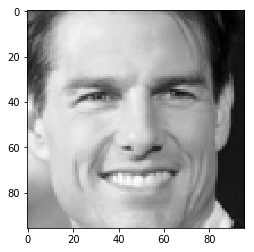

In [11]:
# plot a sample image in gray scale
plt.imshow(X_train[1].reshape(96,96), cmap='gray')

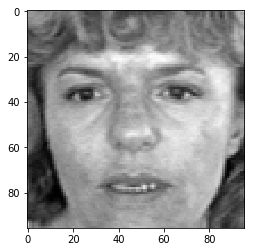

In [12]:
# plot a sample image from validation dataset
plt.imshow(X_valid[1].reshape(96,96), cmap='gray')

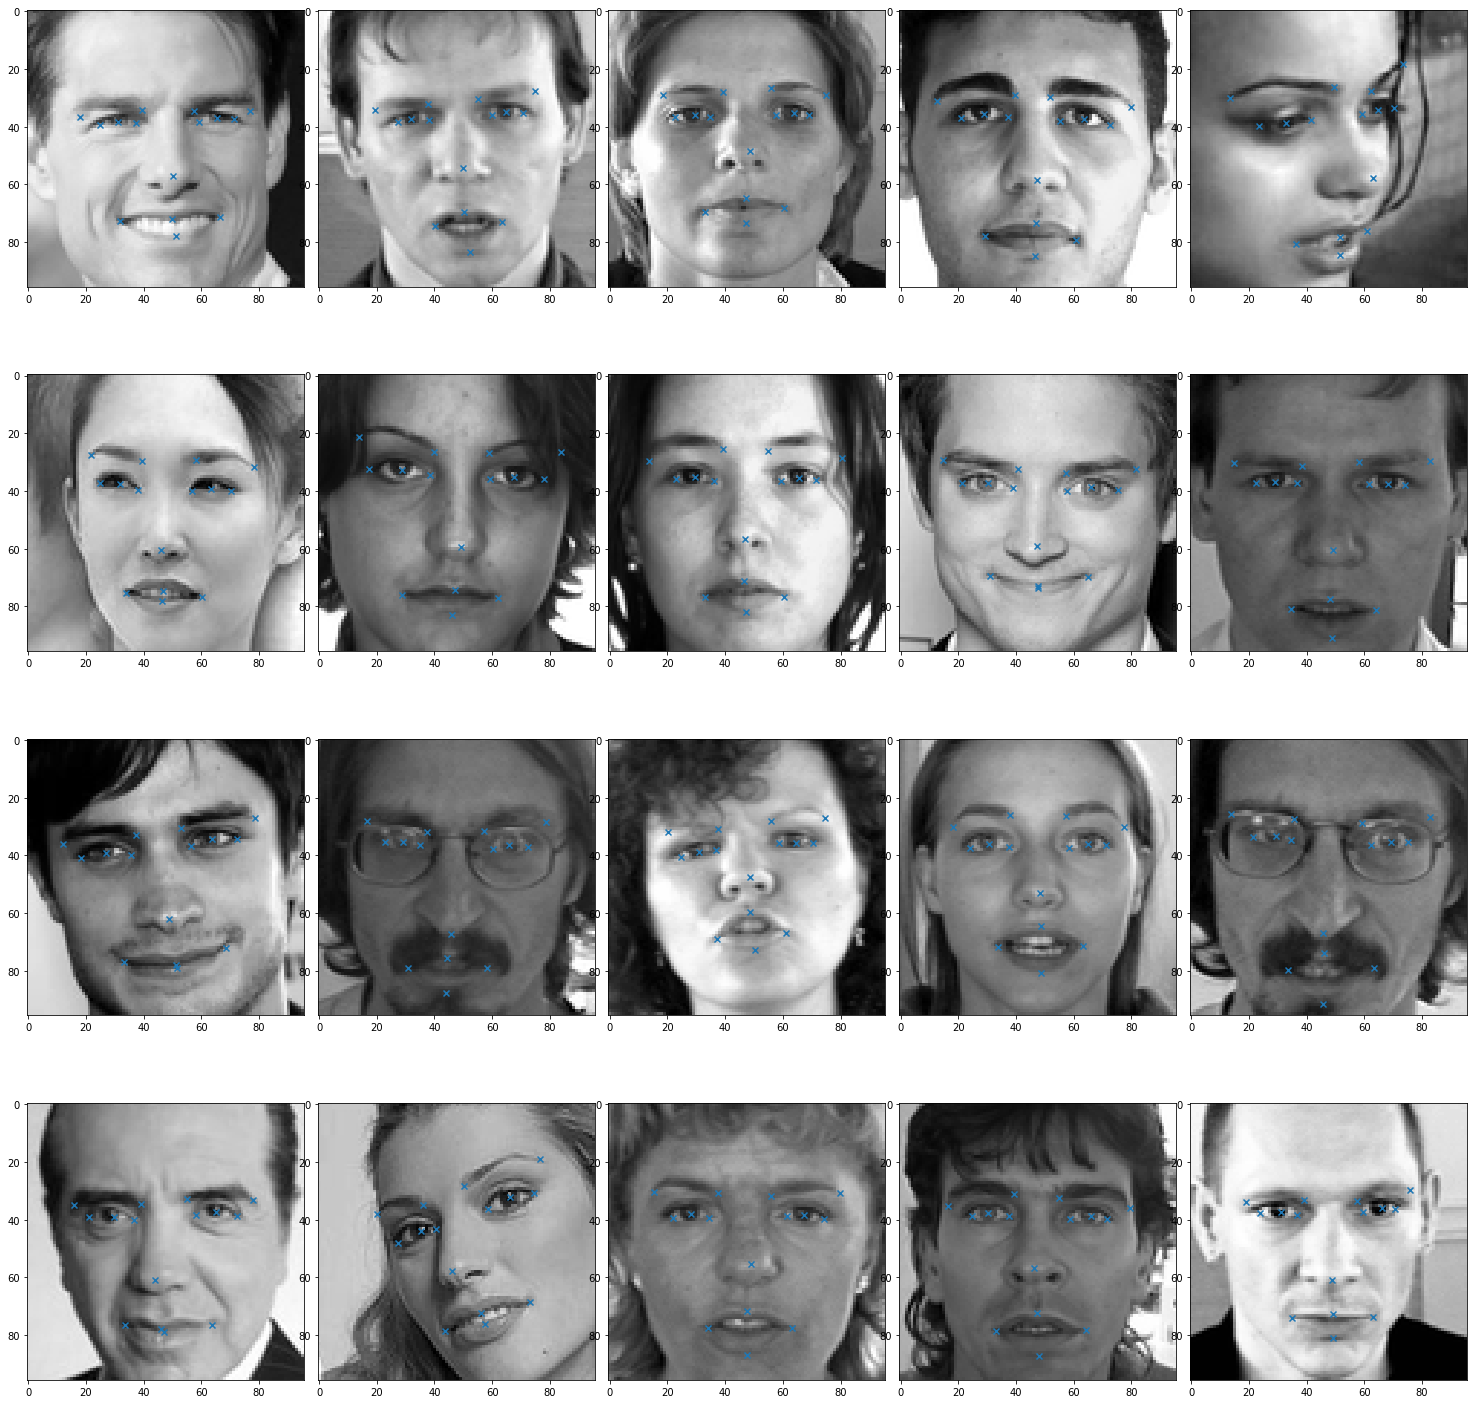

In [13]:
# loop through to print 20 images and their labels
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(1,21):
    plt.subplot(4, 5, i)
    plt.imshow(X_train[i, :, :, 0].reshape(96,96), cmap='gray')
    plt.scatter(y_train[i, range(0,30,2)], y_train[i, range(1,30,2)], marker='x')
    
plt.show()

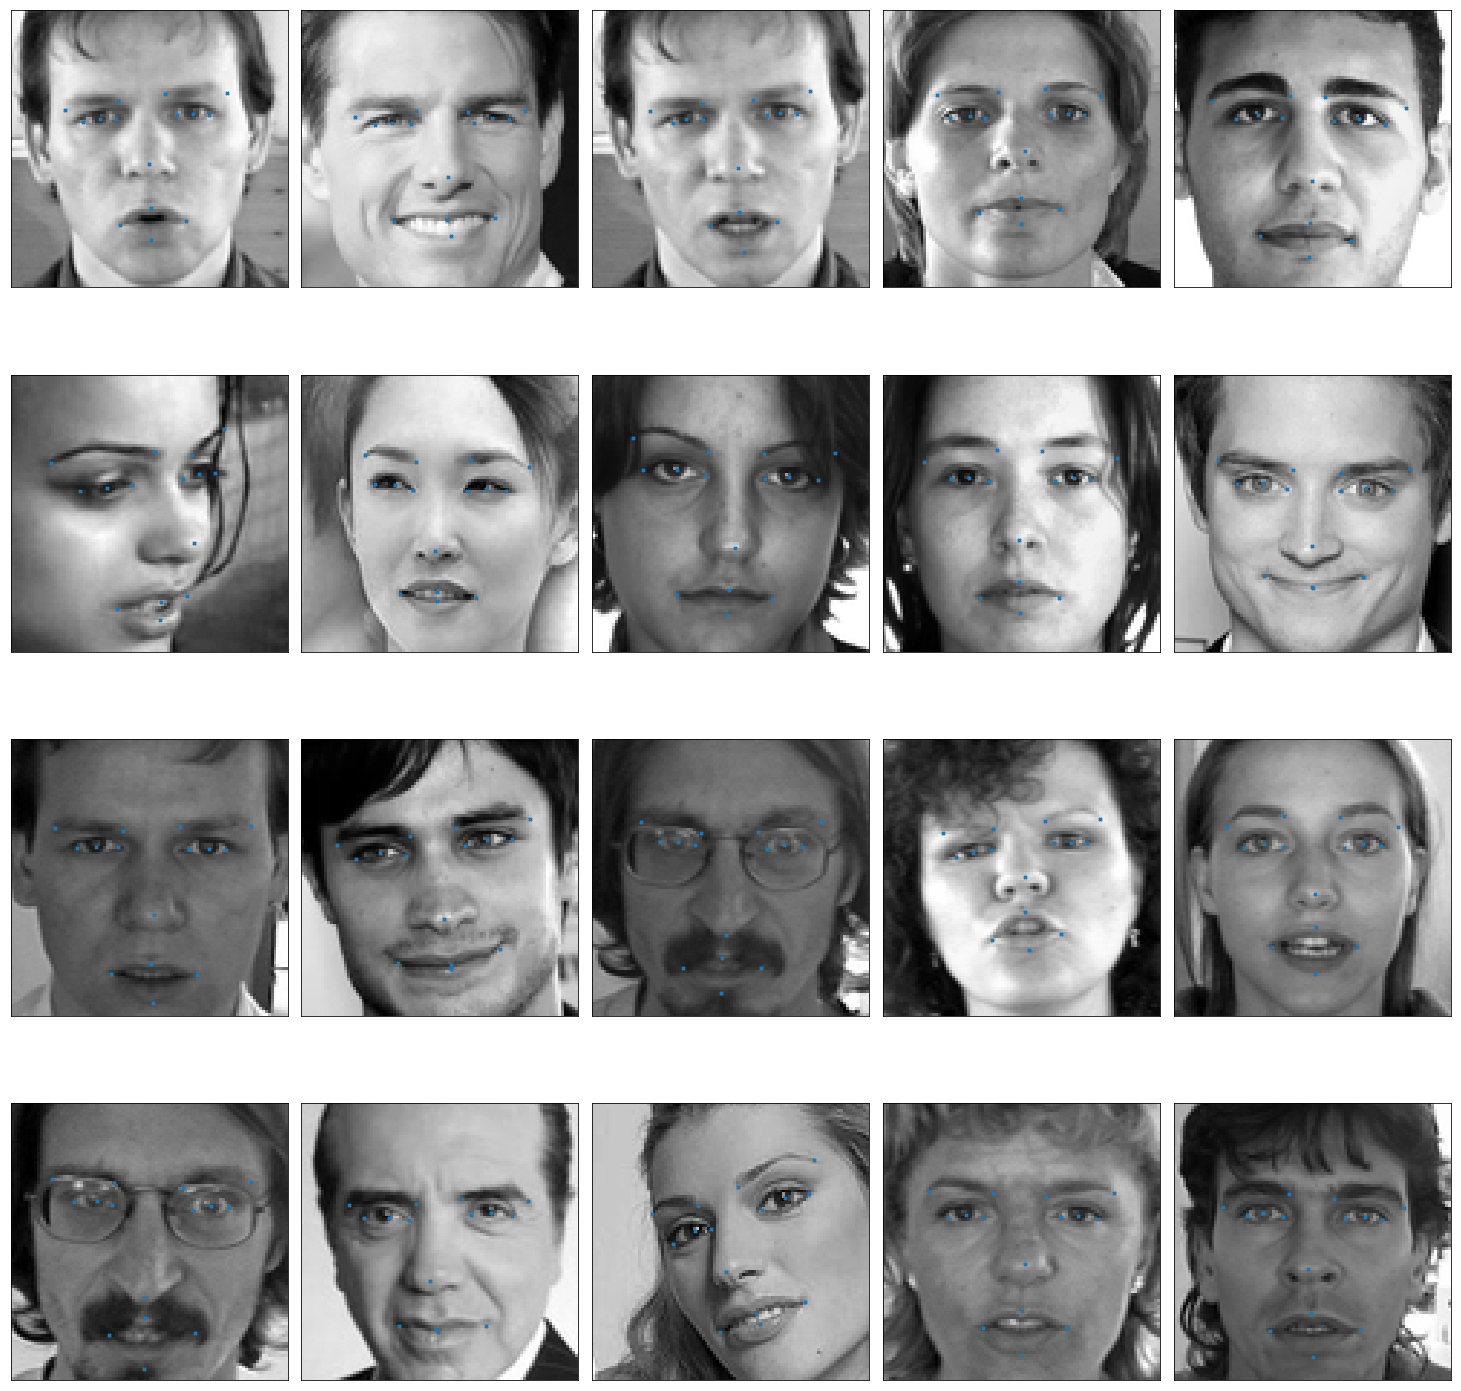

In [14]:
# loop through to print 20 images and their labels
# blue dots indicate the coordinates of the labels in the training set
def plot_img(x, y, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='X', s=10)

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(4,5,i+1, xticks=[], yticks=[])
    plot_img(X_train[i], y_train[i], ax)
    
plt.show()

## IMPORT BUILT MODEL FKP-v3

In [15]:
from keras.models import load_model

In [19]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


In [21]:
# updated back to 'Adam' optimizer; set 1st dense layer to 400 neurons
# The contents of this cell is a capture of the Deep Learning Neural Network Model definition
# The DL-NN model was trained using the training dataset and validated against the validation dataset
# Few custom metrics defined for the model are defined here

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Build model
model = Sequential()

# include batch normalization so image size is same across
model.add(BatchNormalization(input_shape=(96,96,1)))

# Add convolution layers, activation and MaxPooling
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

model.add(Flatten())

model.add(Dense(400))
model.add(Activation("relu"))

model.add(Dense(100))
model.add(Activation("relu"))

# Add dropout layer to address overfitting issues
#model.add(Dropout(0.3))

model.add(Dense(30))

# include custom metrics rmse and r_square
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae', r_square])
#model.compile(optimizer='adam', loss=rmse, metrics=['accuracy', rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 93, 93, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 92, 92, 64)        0         
__________

In [24]:
# this doesn't work, as there are custom metrics
# new_model = load_model('Sudha-FKP-v3.h5')

In [23]:
# Load pre-built model 'Sudha-FKP-v3.h5', which has RMSE of 0.7872 on training set
new_mod = load_model('Sudha-FKP-v3.h5', custom_objects={'rmse': rmse,  'r_square': r_square })

In [41]:
# Make predictions on validation dataset (X_valid)
# y_valid has the actual labels and y_pred will hold the predicted labels
y_pred = new_mod.predict(X_valid)

### Plot of Actual vs. Predictions

Below is a plot of 20 images from the validation dataset, wherein the blue dots indicate the actual labels and red dots indicate the predictions.

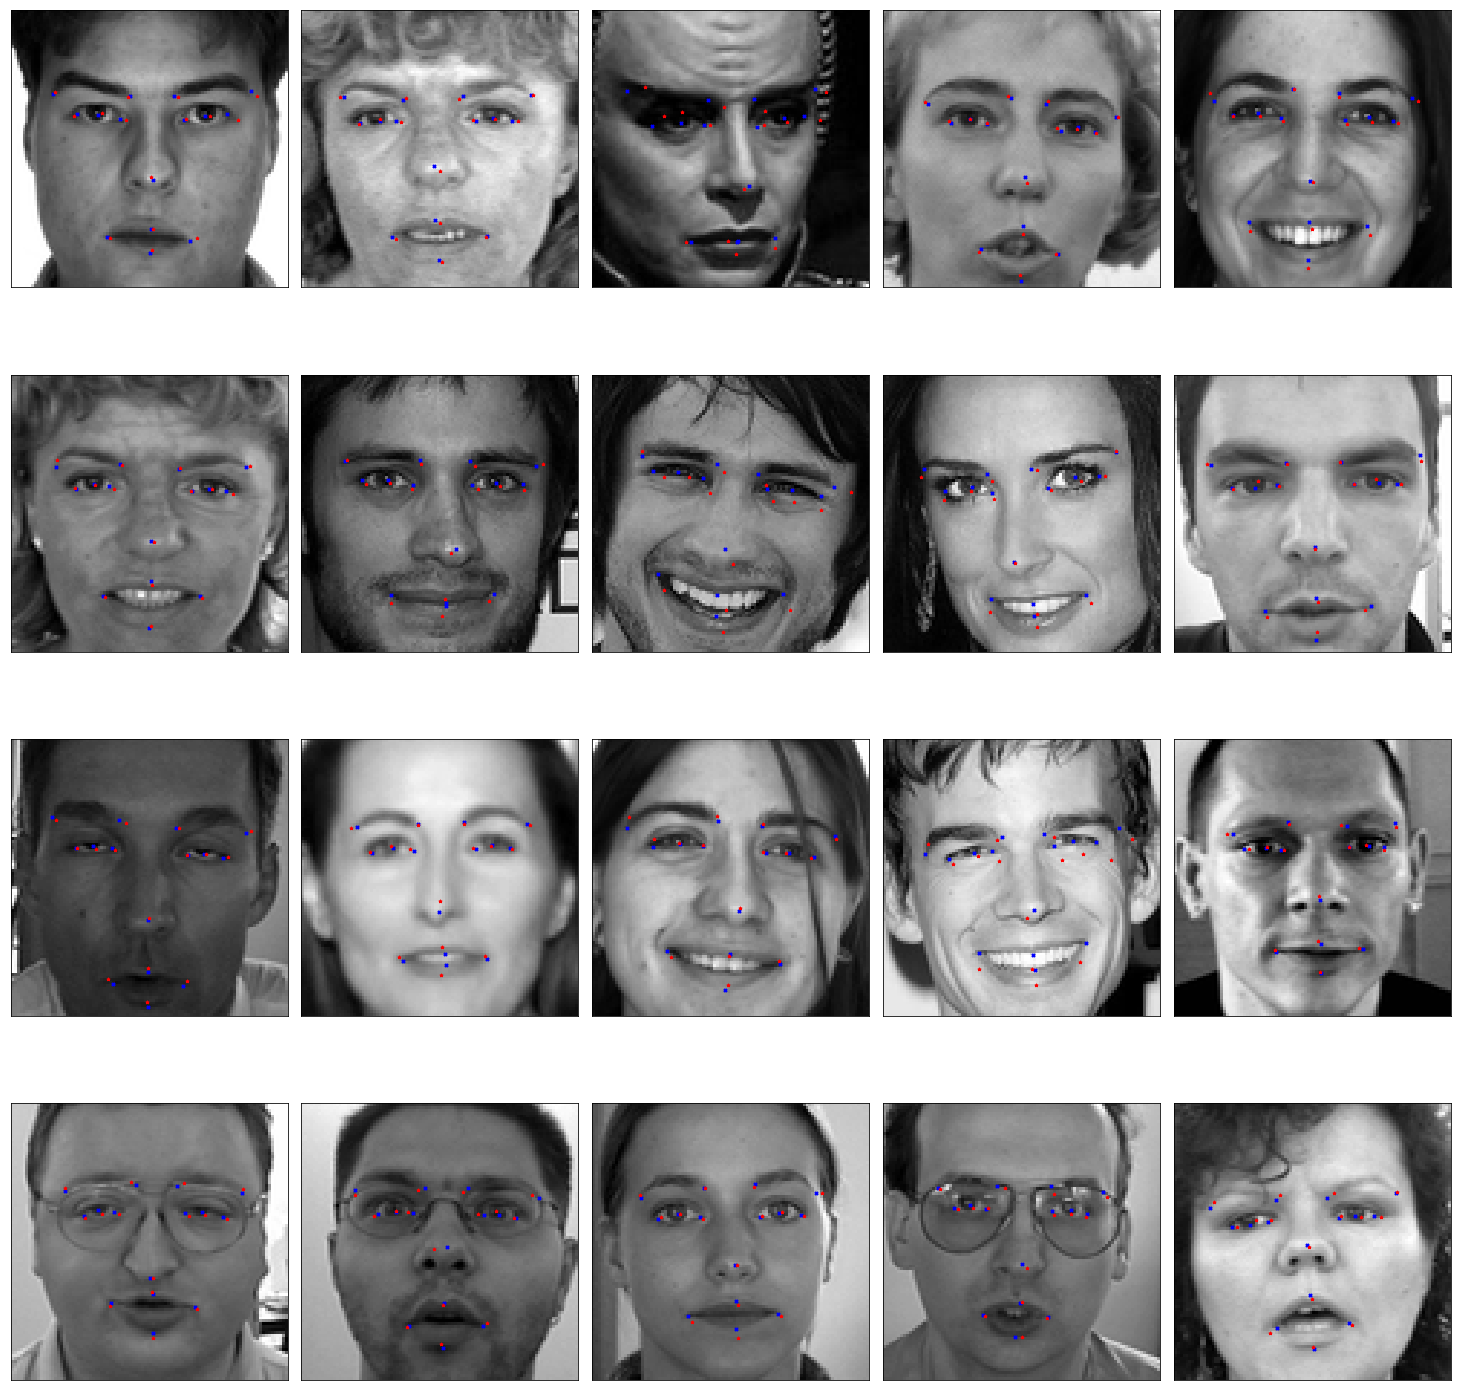

In [54]:
def plot_img(x, y, y_pred, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='X', s=10, color='blue')
    axis.scatter(y_pred[0::2], y_pred[1::2], marker='*', s=10, color='red')

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(4,5,i+1, xticks=[], yticks=[])
    plot_img(X_valid[i], y_valid[i], y_pred[i], ax)
    
plt.show()

In [45]:
y_valid[1]

array([66.05952 , 36.84864 , 26.58912 , 37.70688 , 60.0528  , 37.70688 ,
       72.49536 , 37.70688 , 32.16576 , 37.70688 , 19.72416 , 38.56512 ,
       55.33344 , 29.126496, 78.93024 , 28.697472, 34.74048 , 30.413664,
       14.14656 , 29.55552 , 45.46656 , 53.58144 , 63.91488 , 77.60736 ,
       30.87936 , 78.03648 , 45.89472 , 72.02976 , 47.18208 , 86.18784 ])

In [46]:
y_pred[1]

array([66.54209 , 37.13625 , 26.691671, 37.304867, 59.063915, 37.608307,
       74.439926, 38.020134, 33.85353 , 38.301903, 19.320293, 38.881283,
       54.036613, 30.345306, 79.63541 , 28.954504, 35.58988 , 29.828892,
       12.914478, 29.442451, 47.583664, 55.090828, 63.473827, 77.99159 ,
       32.267822, 78.89917 , 47.61557 , 73.17889 , 48.182846, 86.704056],
      dtype=float32)

In [47]:
# perform predictions on the test dataset
y_testpred = new_mod.predict(X_test)

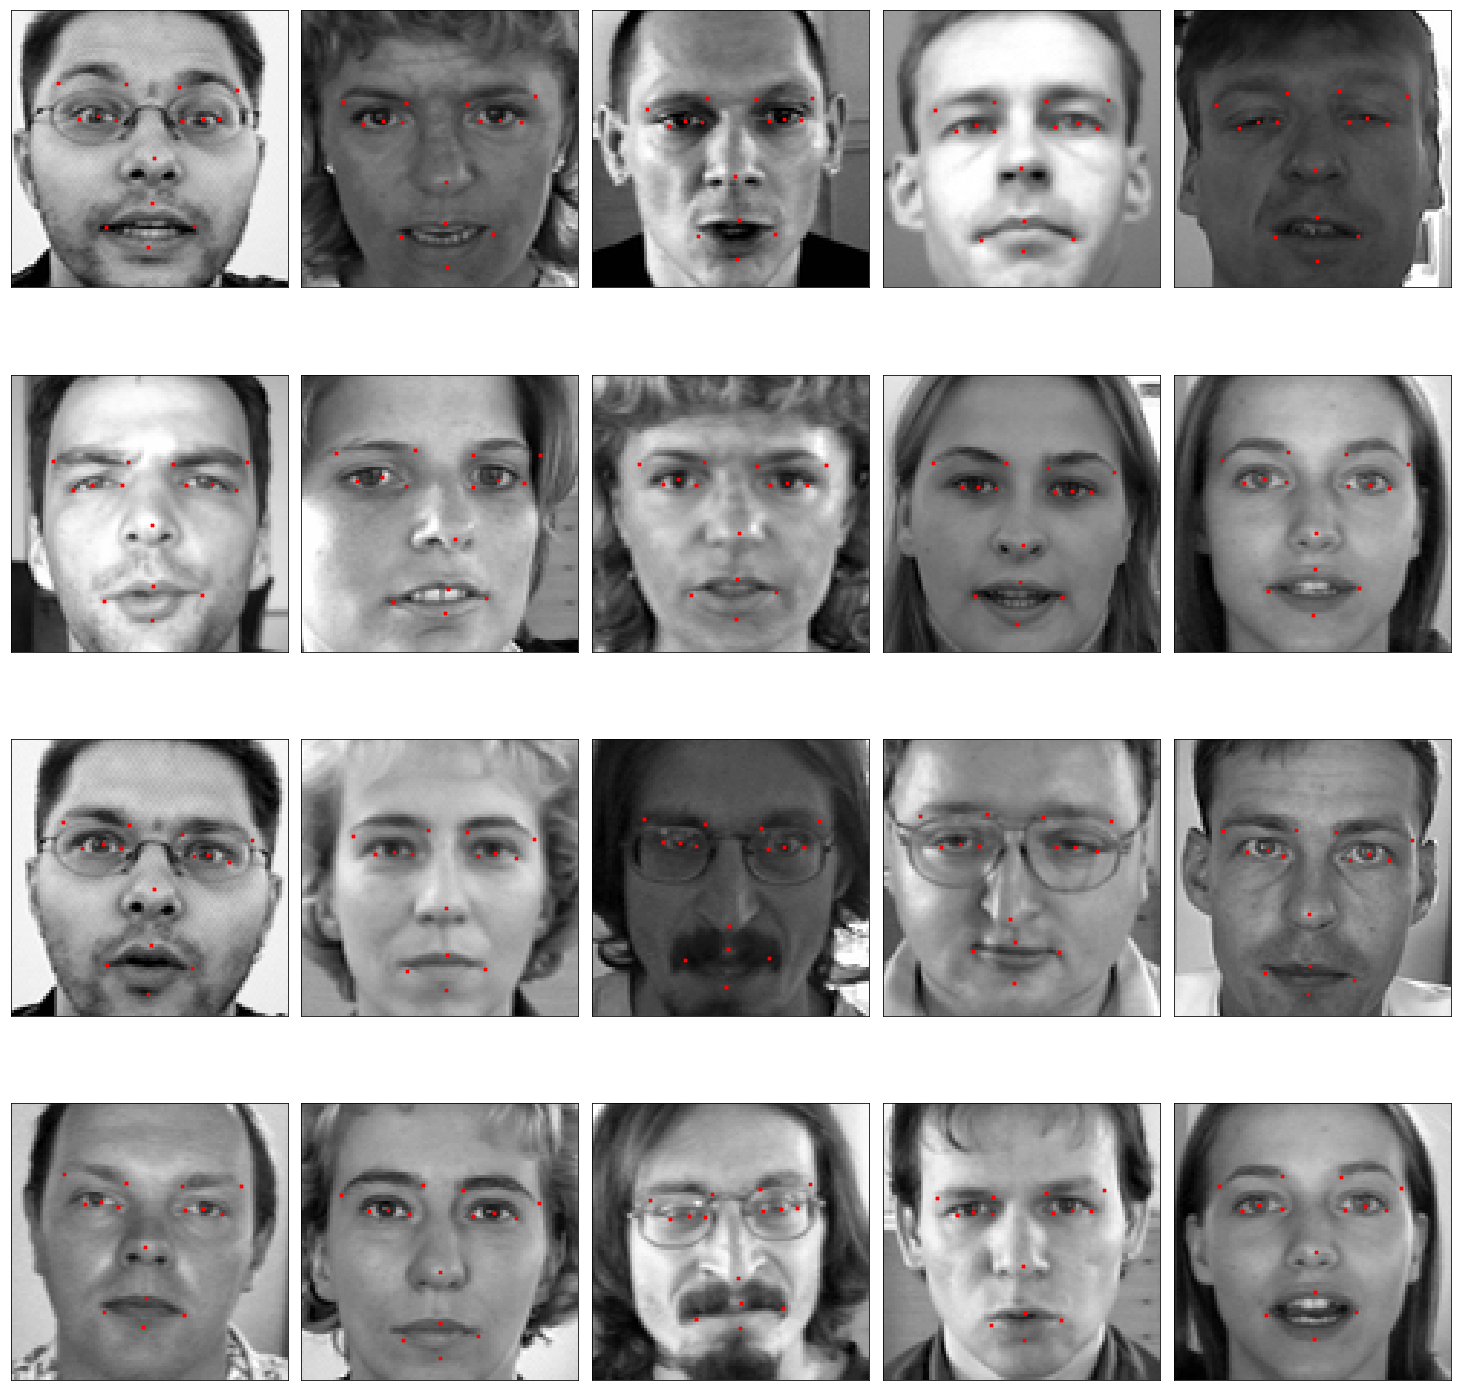

In [57]:
# plot sample images from test set along with predicted coordinates
def plot_img(x, y, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='X', s=10, color='red')

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(4,5,i+1, xticks=[], yticks=[])
    plot_img(X_test[i], y_testpred[i], ax)
    
plt.show()